# Importing

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import string
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from imblearn.over_sampling import ADASYN

import re

[nltk_data] Downloading package punkt to /Users/moseslin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/moseslin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
pd.set_option('max_colwidth', None)

In [3]:
df = pd.read_excel('twitterdata.xlsx')
df.head()

,TweetID,Weekday,Hour,Day,Lang,IsReshare,Reach,RetweetCount,Likes,Klout,Sentiment,text,LocationID,UserID
0,tw-682712873332805633,Thursday,17.0,31.0,en,0.0,44.0,0.0,0.0,35.0,0.0,We are hiring: Senior Software Engineer - Proto http://www.reqcloud.com/jobs/719865/?k=0LaPxXuFwczs1e32ZURJKrgCIDMQtRO7BquFSQthUKY&utm_source=twitter&utm_campaign=reqCloud_JobPost #job @awscloud #job #protocol #networking #aws #mediastreaming,3751.0,tw-40932430
1,tw-682713045357998080,Thursday,17.0,31.0,en,1.0,1810.0,5.0,0.0,53.0,2.0,RT @CodeMineStatus: This is true Amazon Web Services https://aws.amazon.com/ #php #html #html5 #css #webdesign #seo #java #javascript htt,3989.0,tw-3179389829
2,tw-682713219375476736,Thursday,17.0,31.0,en,0.0,282.0,0.0,0.0,47.0,0.0,Devops Engineer Aws Ansible Cassandra Mysql Ubuntu Ruby On Rails Jobs in Austin TX #Austin #TX #jobs #jobsearch https://www.jobfindly.com/devops-engineer-aws-ansible-cassandra-mysql-ubuntu-ruby-on-rails-jobs-austin-tx.html,3741.0,tw-4624808414
3,tw-682713436967579648,Thursday,17.0,31.0,en,0.0,2087.0,4.0,0.0,53.0,0.0,Happy New Year to all those AWS instances of ours!,3753.0,tw-356447127
4,tw-682714048199311366,Thursday,17.0,31.0,en,0.0,953.0,0.0,0.0,47.0,0.0,Amazon is hiring! #Sr. #International Tax Manager - AWS in #Seattle apply now! #jobs http://neuvoo.com/job.php?id=dsvkrujig3&source=twitter&lang=en&client_id=658&l=Seattle%20Washington%20US&k=Sr.%20International%20Tax%20Manager%20-%20AWS http://twitter.com/NeuvooAccSea/status/682714048199311366/photo/1,3751.0,tw-3172686669


# Cleaning

In [4]:
# Re-naming so they are more manageable

df.columns = ['tweetid', 'weekday', 'hour', 'day', 'lang', 'isreshare', 'reach', 'retweetcount', 'likes', 'klout', 'sentiment', 'text', 'locationid', 'userid']
df.columns

Index(['tweetid', 'weekday', 'hour', 'day', 'lang', 'isreshare', 'reach',
       'retweetcount', 'likes', 'klout', 'sentiment', 'text', 'locationid',
       'userid'],
      dtype='object')

In [5]:
# Majority of tweets are in english.

df = df.loc[df['lang'] == 'en']
df.drop(columns=['lang'], inplace=True)

In [6]:
# We want to only work with a few sentiment values.

df['sentiment'].value_counts().head(15)

 0.000000    61365
 1.000000     8723
 2.000000     8556
 3.000000     3833
-1.000000     1762
-2.000000     1717
 1.500000     1160
 4.000000      796
 2.500000      691
 0.500000      537
-3.000000      490
-0.500000      273
-1.500000      223
-4.000000      213
 2.666667      160
Name: sentiment, dtype: int64

In [7]:
# Removing rows that do not have the values we want.

sentimentlist = [0.0, 1.0, 2.0, 3.0, -1.0, -2.0, -3.0]
df = df.loc[df.sentiment.isin(sentimentlist)]

In [8]:
# Removing null values as they mess up code

df['text'].dropna(inplace=True)

In [9]:
# Looking at what we are working with

list(df['text'])[:5]

['We are hiring: Senior Software Engineer - Proto http://www.reqcloud.com/jobs/719865/?k=0LaPxXuFwczs1e32ZURJKrgCIDMQtRO7BquFSQthUKY&utm_source=twitter&utm_campaign=reqCloud_JobPost #job @awscloud #job #protocol #networking #aws #mediastreaming',
 'RT @CodeMineStatus: This is true Amazon Web Services https://aws.amazon.com/ #php #html #html5 #css #webdesign #seo #java #javascript htt',
 'Devops Engineer Aws Ansible Cassandra Mysql Ubuntu Ruby On Rails Jobs in Austin TX #Austin #TX #jobs #jobsearch https://www.jobfindly.com/devops-engineer-aws-ansible-cassandra-mysql-ubuntu-ruby-on-rails-jobs-austin-tx.html',
 'Happy New Year to all those AWS instances of ours!',
 'Amazon is hiring! #Sr. #International Tax Manager - AWS in #Seattle apply now! #jobs http://neuvoo.com/job.php?id=dsvkrujig3&source=twitter&lang=en&client_id=658&l=Seattle%20Washington%20US&k=Sr.%20International%20Tax%20Manager%20-%20AWS http://twitter.com/NeuvooAccSea/status/682714048199311366/photo/1']

# Getting Links

We want to remove links from the tweets to make it easier to tokenize the actual tweets. However we want to keep the links, should they exist for a tweet.

In [10]:
url = df['text'].str.findall(r'(http\S+)')
url.head(3)

0    [http://www.reqcloud.com/jobs/719865/?k=0LaPxXuFwczs1e32ZURJKrgCIDMQtRO7BquFSQthUKY&utm_source=twitter&utm_campaign=reqCloud_JobPost]
1                                                                                                                [https://aws.amazon.com/]
2                         [https://www.jobfindly.com/devops-engineer-aws-ansible-cassandra-mysql-ubuntu-ruby-on-rails-jobs-austin-tx.html]
Name: text, dtype: object

In [11]:
df['links'] = pd.DataFrame(url)
df

,tweetid,weekday,hour,day,isreshare,reach,retweetcount,likes,klout,sentiment,text,locationid,userid,links
0,tw-682712873332805633,Thursday,17.0,31.0,0.0,44.0,0.0,0.0,35.0,0.0,We are hiring: Senior Software Engineer - Proto http://www.reqcloud.com/jobs/719865/?k=0LaPxXuFwczs1e32ZURJKrgCIDMQtRO7BquFSQthUKY&utm_source=twitter&utm_campaign=reqCloud_JobPost #job @awscloud #job #protocol #networking #aws #mediastreaming,3751.0,tw-40932430,[http://www.reqcloud.com/jobs/719865/?k=0LaPxXuFwczs1e32ZURJKrgCIDMQtRO7BquFSQthUKY&utm_source=twitter&utm_campaign=reqCloud_JobPost]
1,tw-682713045357998080,Thursday,17.0,31.0,1.0,1810.0,5.0,0.0,53.0,2.0,RT @CodeMineStatus: This is true Amazon Web Services https://aws.amazon.com/ #php #html #html5 #css #webdesign #seo #java #javascript htt,3989.0,tw-3179389829,[https://aws.amazon.com/]
2,tw-682713219375476736,Thursday,17.0,31.0,0.0,282.0,0.0,0.0,47.0,0.0,Devops Engineer Aws Ansible Cassandra Mysql Ubuntu Ruby On Rails Jobs in Austin TX #Austin #TX #jobs #jobsearch https://www.jobfindly.com/devops-engineer-aws-ansible-cassandra-mysql-ubuntu-ruby-on-rails-jobs-austin-tx.html,3741.0,tw-4624808414,[https://www.jobfindly.com/devops-engineer-aws-ansible-cassandra-mysql-ubuntu-ruby-on-rails-jobs-austin-tx.html]
3,tw-682713436967579648,Thursday,17.0,31.0,0.0,2087.0,4.0,0.0,53.0,0.0,Happy New Year to all those AWS instances of ours!,3753.0,tw-356447127,[]
4,tw-682714048199311366,Thursday,17.0,31.0,0.0,953.0,0.0,0.0,47.0,0.0,Amazon is hiring! #Sr. #International Tax Manager - AWS in #Seattle apply now! #jobs http://neuvoo.com/job.php?id=dsvkrujig3&source=twitter&lang=en&client_id=658&l=Seattle%20Washington%20US&k=Sr.%20International%20Tax%20Manager%20-%20AWS http://twitter.com/NeuvooAccSea/status/682714048199311366/photo/1,3751.0,tw-3172686669,"[http://neuvoo.com/job.php?id=dsvkrujig3&source=twitter&lang=en&client_id=658&l=Seattle%20Washington%20US&k=Sr.%20International%20Tax%20Manager%20-%20AWS, http://twitter.com/NeuvooAccSea/status/682714048199311366/photo/1]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,tw-716349383688720385,Saturday,13.0,2.0,1.0,415.0,15.0,0.0,44.0,0.0,RT @awscloud: .@Jaspersoft built a #DataWarehouse that provides full cloud analytics using Redshift &amp; EMR! https://aws.amazon.com/solutions/case-studies/jaspersoft/?sc_channel=sm&sc_campaign=gc_dw&sc_publisher=tw_go&sc_content=jaspersoft&sc_country=global&sc_geo=global&sc_category=data_warehouse&trk=global_2016_data_warehouse&adbsc=gc_20160402_59959296&adbid=716285623842123776&adbpl=tw&adbpr=66780587 https://,611.0,tw-3316009302,"[https://aws.amazon.com/solutions/case-studies/jaspersoft/?sc_channel=sm&sc_campaign=gc_dw&sc_publisher=tw_go&sc_content=jaspersoft&sc_country=global&sc_geo=global&sc_category=data_warehouse&trk=global_2016_data_warehouse&adbsc=gc_20160402_59959296&adbid=716285623842123776&adbpl=tw&adbpr=66780587, https://]"
99996,tw-716349615340199937,Saturday,13.0,2.0,0.0,763.0,0.0,0.0,29.0,0.0,I added a video to a @YouTube playlist https://www.youtube.com/watch?v=YPf7wSEq9d0&feature=youtu.be&a Module 3 : AWS EC2 Instance Status Checks (System and Instance level),1332.0,tw-1143330170,[https://www.youtube.com/watch?v=YPf7wSEq9d0&feature=youtu.be&a]
99997,tw-716351557516722176,Saturday,13.0,2.0,1.0,122.0,435.0,0.0,17.0,1.0,RT @awscloud: Test your iOS Android &amp; web apps against real phones and tablets on AWS. Start today for free! https://cards.twitter.com/cards/13rc8b/1ihbc,1336.0,tw-139346924,[https://cards.twitter.com/cards/13rc8b/1ihbc]
99998,tw-716352501860196352,Saturday,13.0,2.0,1.0,287.0,30.0,0.0,42.0,0.0,RT @goserverless: Serverless Offline: Emulate AWS Lambda &amp; API Gateway locally to speed up your development cycles - https://t.co/CcXASlhQq,3795.0,tw-21826302,[https://t.co/CcXASlhQq]


# Removing links from tweets

In [12]:
df['text'].dropna(inplace=True)

In [13]:
def removelink(tweet):
    result = re.sub(r"http\S+", "", tweet)
    return result

In [14]:
df['text'] = df['text'].apply(lambda x: removelink(x))
df

,tweetid,weekday,hour,day,isreshare,reach,retweetcount,likes,klout,sentiment,text,locationid,userid,links
0,tw-682712873332805633,Thursday,17.0,31.0,0.0,44.0,0.0,0.0,35.0,0.0,We are hiring: Senior Software Engineer - Proto #job @awscloud #job #protocol #networking #aws #mediastreaming,3751.0,tw-40932430,[http://www.reqcloud.com/jobs/719865/?k=0LaPxXuFwczs1e32ZURJKrgCIDMQtRO7BquFSQthUKY&utm_source=twitter&utm_campaign=reqCloud_JobPost]
1,tw-682713045357998080,Thursday,17.0,31.0,1.0,1810.0,5.0,0.0,53.0,2.0,RT @CodeMineStatus: This is true Amazon Web Services #php #html #html5 #css #webdesign #seo #java #javascript htt,3989.0,tw-3179389829,[https://aws.amazon.com/]
2,tw-682713219375476736,Thursday,17.0,31.0,0.0,282.0,0.0,0.0,47.0,0.0,Devops Engineer Aws Ansible Cassandra Mysql Ubuntu Ruby On Rails Jobs in Austin TX #Austin #TX #jobs #jobsearch,3741.0,tw-4624808414,[https://www.jobfindly.com/devops-engineer-aws-ansible-cassandra-mysql-ubuntu-ruby-on-rails-jobs-austin-tx.html]
3,tw-682713436967579648,Thursday,17.0,31.0,0.0,2087.0,4.0,0.0,53.0,0.0,Happy New Year to all those AWS instances of ours!,3753.0,tw-356447127,[]
4,tw-682714048199311366,Thursday,17.0,31.0,0.0,953.0,0.0,0.0,47.0,0.0,Amazon is hiring! #Sr. #International Tax Manager - AWS in #Seattle apply now! #jobs,3751.0,tw-3172686669,"[http://neuvoo.com/job.php?id=dsvkrujig3&source=twitter&lang=en&client_id=658&l=Seattle%20Washington%20US&k=Sr.%20International%20Tax%20Manager%20-%20AWS, http://twitter.com/NeuvooAccSea/status/682714048199311366/photo/1]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,tw-716349383688720385,Saturday,13.0,2.0,1.0,415.0,15.0,0.0,44.0,0.0,RT @awscloud: .@Jaspersoft built a #DataWarehouse that provides full cloud analytics using Redshift &amp; EMR!,611.0,tw-3316009302,"[https://aws.amazon.com/solutions/case-studies/jaspersoft/?sc_channel=sm&sc_campaign=gc_dw&sc_publisher=tw_go&sc_content=jaspersoft&sc_country=global&sc_geo=global&sc_category=data_warehouse&trk=global_2016_data_warehouse&adbsc=gc_20160402_59959296&adbid=716285623842123776&adbpl=tw&adbpr=66780587, https://]"
99996,tw-716349615340199937,Saturday,13.0,2.0,0.0,763.0,0.0,0.0,29.0,0.0,I added a video to a @YouTube playlist Module 3 : AWS EC2 Instance Status Checks (System and Instance level),1332.0,tw-1143330170,[https://www.youtube.com/watch?v=YPf7wSEq9d0&feature=youtu.be&a]
99997,tw-716351557516722176,Saturday,13.0,2.0,1.0,122.0,435.0,0.0,17.0,1.0,RT @awscloud: Test your iOS Android &amp; web apps against real phones and tablets on AWS. Start today for free!,1336.0,tw-139346924,[https://cards.twitter.com/cards/13rc8b/1ihbc]
99998,tw-716352501860196352,Saturday,13.0,2.0,1.0,287.0,30.0,0.0,42.0,0.0,RT @goserverless: Serverless Offline: Emulate AWS Lambda &amp; API Gateway locally to speed up your development cycles -,3795.0,tw-21826302,[https://t.co/CcXASlhQq]


# Tokenizing

In [15]:
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``', 'aws', 'rt', 'amazon', 'awscloud', 'cloud']
stopwords_list += ["'s", "n't"]

# removing several extremely common words like aws, amazon, awscloud, which most of these tweets refer to.
# removing weird stuff like 's and n't

In [16]:
def process_things(things):
    tokens = nltk.word_tokenize(things)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed

In [17]:
df['text'].dropna(inplace=True)

In [18]:
data = list(map(process_things, df['text']))
# concatenating list of lists into flat list
alldata = [item for elem in data for item in elem]


# checking to see how many of each we have and if it worked
print(len(data))
print(len(alldata))

86445
746599


In [19]:
lemmatizer = WordNetLemmatizer()
lemdata = []
for i in alldata:
    lemdata.append(lemmatizer.lemmatize(i))
    
len(lemdata)

746599

In [20]:
# Checking total unique words
# Takes a while to run

# total_vocab = []
# for word in alldata:
#    if word not in total_vocab:
#        total_vocab.append(word)
# len(total_vocab)

In [21]:
# Checking top 20 most common words

data_freqdist = FreqDist(lemdata)
data_freqdist.most_common(20)

[('service', 13931),
 ('job', 10081),
 ('web', 9152),
 ('new', 7683),
 ('amp', 6687),
 ('lambda', 5834),
 ('engineer', 4968),
 ('azure', 4661),
 ('data', 4404),
 ('google', 4309),
 ('hiring', 3642),
 ('blog', 3641),
 ('using', 3545),
 ('via', 3496),
 ('devops', 3364),
 ('free', 3106),
 ('learn', 3089),
 ('security', 2920),
 ('support', 2848),
 ('manager', 2562)]

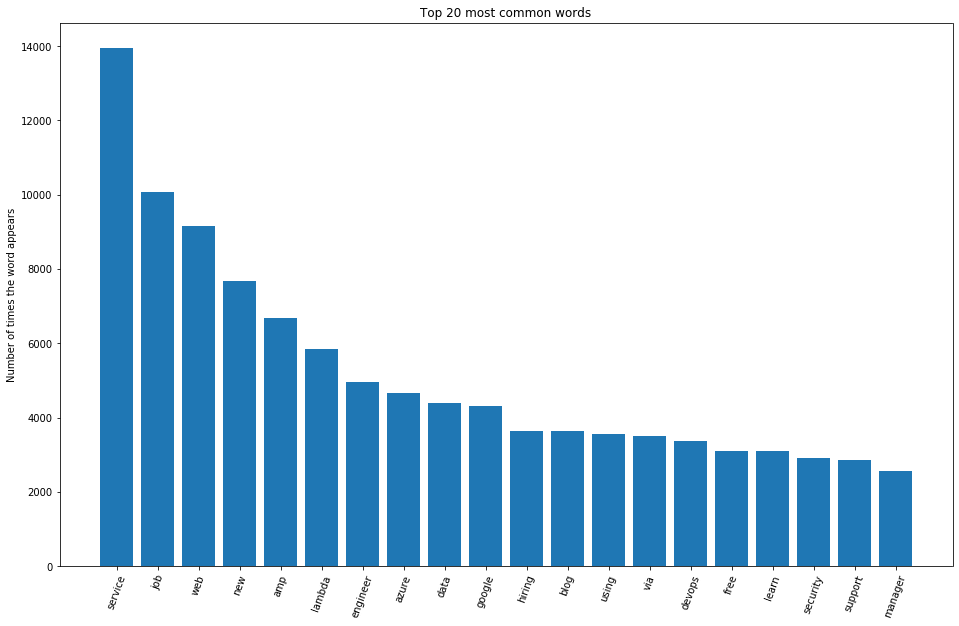

In [22]:
mostcommonwords20 = data_freqdist.most_common(20)

plt.figure(figsize=(16, 10))
plt.bar(range(len(mostcommonwords20)), [val[1] for val in mostcommonwords20], align='center')
plt.xticks(range(len(mostcommonwords20)), [val[0] for val in mostcommonwords20])
plt.xticks(rotation=70)
plt.ylabel('Number of times the word appears')
plt.title('Top 20 most common words')
plt.show()

# EDA for all sentiment types

================================================================================================================

## EDA for Sentiment 0

In [23]:
dfsent0 = df.loc[df['sentiment'] == 0.0]
dfsent0['text']

dfsent0['text'].dropna(inplace=True)

datasent0 = list(map(process_things, dfsent0['text']))
datasent0

alldatasent0 = [item for elem in datasent0 for item in elem]
alldatasent0

data_freqdistsent0 = FreqDist(alldatasent0)
data_freqdistsent0.most_common(20)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(result)


[('services', 8030),
 ('web', 7037),
 ('new', 6145),
 ('jobs', 4845),
 ('job', 4519),
 ('engineer', 4209),
 ('lambda', 4088),
 ('amp', 3838),
 ('hiring', 3408),
 ('azure', 3322),
 ('data', 3229),
 ('blog', 3175),
 ('google', 2922),
 ('service', 2785),
 ('devops', 2738),
 ('via', 2567),
 ('using', 2519),
 ('seattle', 2340),
 ('security', 2224),
 ('software', 2178)]

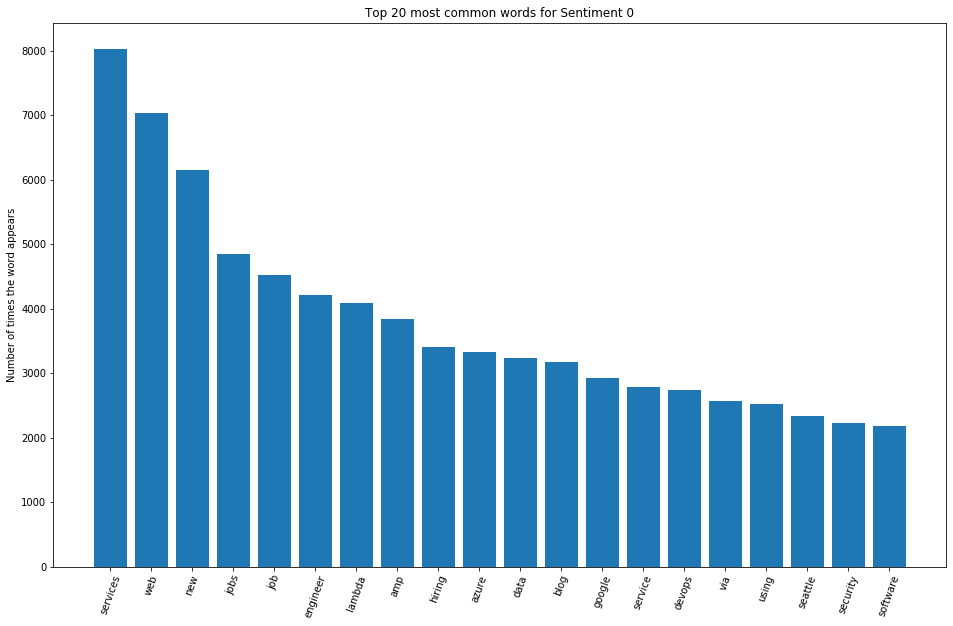

In [24]:
mostcommonwords20sent0 = data_freqdistsent0.most_common(20)

plt.figure(figsize=(16, 10))
plt.bar(range(len(mostcommonwords20sent0)), [val[1] for val in mostcommonwords20sent0], align='center')
plt.xticks(range(len(mostcommonwords20sent0)), [val[0] for val in mostcommonwords20sent0])
plt.xticks(rotation=70)
plt.ylabel('Number of times the word appears')
plt.title('Top 20 most common words for Sentiment 0')
plt.show()

## EDA for Positive Sentiment values.

In [25]:
dfsent1 = df.loc[df['sentiment'] == 1.0]
dfsent1['text']

dfsent1['text'].dropna(inplace=True)

datasent1 = list(map(process_things, dfsent1['text']))
datasent1

alldatasent1 = [item for elem in datasent1 for item in elem]
alldatasent1

data_freqdistsent1 = FreqDist(alldatasent1)
data_freqdistsent1.most_common(20)

[('free', 2595),
 ('amp', 1313),
 ('join', 1137),
 ('services', 1039),
 ('web', 875),
 ('new', 664),
 ('certificates', 631),
 ('lambda', 603),
 ('us', 598),
 ('learn', 570),
 ('data', 517),
 ('big', 489),
 ('ssl', 462),
 ('google', 444),
 ('azure', 432),
 ('via', 397),
 ('want', 381),
 ('today', 378),
 ('using', 369),
 ('launched', 359)]

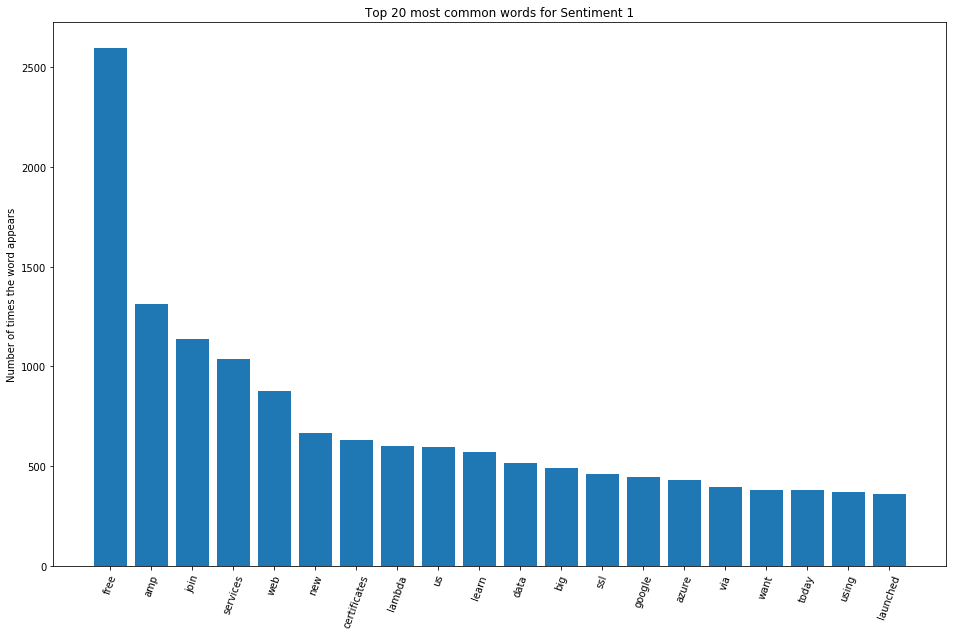

In [26]:
mostcommonwords20sent1 = data_freqdistsent1.most_common(20)

plt.figure(figsize=(16, 10))
plt.bar(range(len(mostcommonwords20sent1)), [val[1] for val in mostcommonwords20sent1], align='center')
plt.xticks(range(len(mostcommonwords20sent1)), [val[0] for val in mostcommonwords20sent1])
plt.xticks(rotation=70)
plt.ylabel('Number of times the word appears')
plt.title('Top 20 most common words for Sentiment 1')
plt.show()

In [27]:
dfsent2 = df.loc[df['sentiment'] == 2.0]
dfsent2['text']

dfsent2['text'].dropna(inplace=True)

datasent2 = list(map(process_things, dfsent2['text']))
datasent2

alldatasent2 = [item for elem in datasent2 for item in elem]
alldatasent2

data_freqdistsent2 = FreqDist(alldatasent2)
data_freqdistsent2.most_common(20)

[('amp', 1135),
 ('support', 1007),
 ('supports', 993),
 ('help', 748),
 ('services', 562),
 ('new', 555),
 ('web', 533),
 ('use', 482),
 ('learn', 477),
 ('lambda', 463),
 ('instances', 456),
 ('using', 428),
 ('interesting', 369),
 ('data', 352),
 ('save', 335),
 ('secure', 332),
 ('service', 320),
 ('iot', 318),
 ('thanks', 311),
 ('security', 303)]

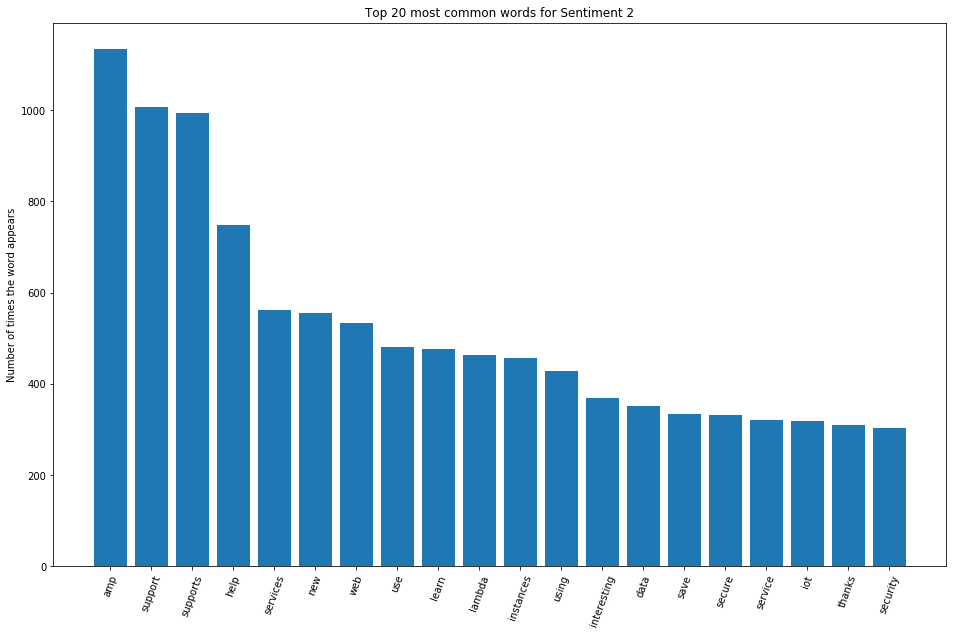

In [28]:
mostcommonwords20sent2 = data_freqdistsent2.most_common(20)

plt.figure(figsize=(16, 10))
plt.bar(range(len(mostcommonwords20sent2)), [val[1] for val in mostcommonwords20sent2], align='center')
plt.xticks(range(len(mostcommonwords20sent2)), [val[0] for val in mostcommonwords20sent2])
plt.xticks(rotation=70)
plt.ylabel('Number of times the word appears')
plt.title('Top 20 most common words for Sentiment 2')
plt.show()

In [29]:
dfsent3 = df.loc[df['sentiment'] == 3.0]
dfsent3['text']

dfsent3['text'].dropna(inplace=True)

datasent3 = list(map(process_things, dfsent3['text']))
datasent3

alldatasent3 = [item for elem in datasent3 for item in elem]
alldatasent3

data_freqdistsent3 = FreqDist(alldatasent3)
data_freqdistsent3.most_common(20)

[('nice', 903),
 ('great', 649),
 ('computing', 506),
 ('best', 468),
 ('high', 468),
 ('performance', 456),
 ('good', 450),
 ('offering', 448),
 ('acquisition', 424),
 ('bolsters', 423),
 ('services', 341),
 ('web', 323),
 ('lambda', 212),
 ('10', 206),
 ('amp', 193),
 ('practices', 183),
 ('years', 180),
 ('happy', 175),
 ('new', 164),
 ('azure', 156)]

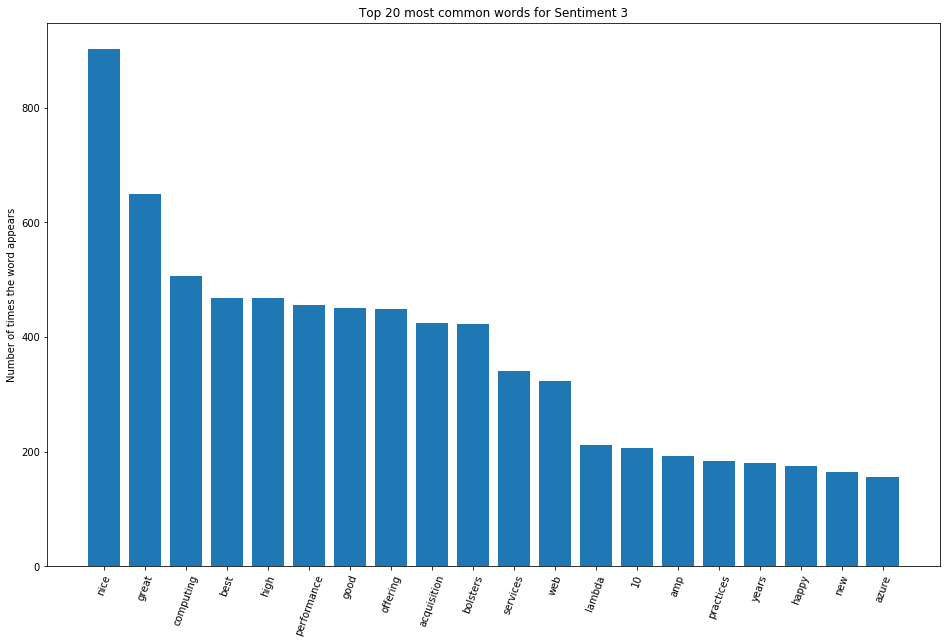

In [30]:
mostcommonwords20sent3 = data_freqdistsent3.most_common(20)

plt.figure(figsize=(16, 10))
plt.bar(range(len(mostcommonwords20sent3)), [val[1] for val in mostcommonwords20sent3], align='center')
plt.xticks(range(len(mostcommonwords20sent3)), [val[0] for val in mostcommonwords20sent3])
plt.xticks(rotation=70)
plt.ylabel('Number of times the word appears')
plt.title('Top 20 most common words for Sentiment 3')
plt.show()

## EDA for Negative Sentiment values.

In [31]:
dfsentneg1 = df.loc[df['sentiment'] == -1.0]
dfsentneg1['text']

dfsentneg1['text'].dropna(inplace=True)

datasentneg1 = list(map(process_things, dfsentneg1['text']))
datasentneg1

alldatasentneg1 = [item for elem in datasentneg1 for item in elem]
alldatasentneg1

data_freqdistsentneg1 = FreqDist(alldatasentneg1)
data_freqdistsentneg1.most_common(20)

[('cuts', 423),
 ('google', 288),
 ('price', 198),
 ('azure', 188),
 ('prices', 185),
 ('microsoft', 145),
 ('still', 136),
 ('services', 123),
 ('apple', 119),
 ('instances', 118),
 ('challenge', 115),
 ('via', 114),
 ('says', 113),
 ('web', 109),
 ('way', 98),
 ('amp', 93),
 ('lambda', 92),
 ('cut', 91),
 ('data', 91),
 ('cheaper', 86)]

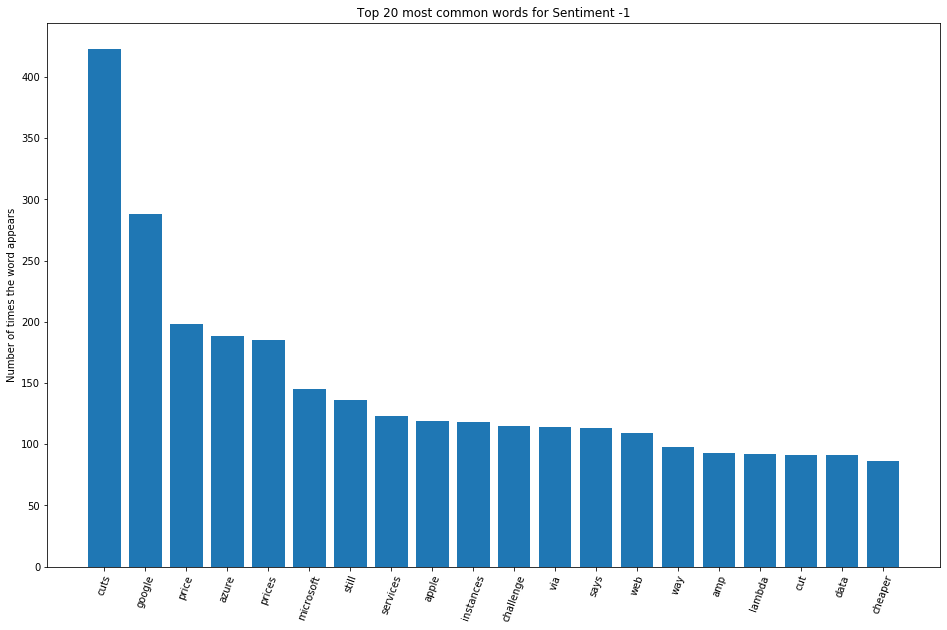

In [32]:
mostcommonwords20sentneg1 = data_freqdistsentneg1.most_common(20)

plt.figure(figsize=(16, 10))
plt.bar(range(len(mostcommonwords20sentneg1)), [val[1] for val in mostcommonwords20sentneg1], align='center')
plt.xticks(range(len(mostcommonwords20sentneg1)), [val[0] for val in mostcommonwords20sentneg1])
plt.xticks(rotation=70)
plt.ylabel('Number of times the word appears')
plt.title('Top 20 most common words for Sentiment -1')
plt.show()

In [33]:
dfsentneg2 = df.loc[df['sentiment'] == -2.0]
dfsentneg2['text']

dfsentneg2['text'].dropna(inplace=True)

datasentneg2 = list(map(process_things, dfsentneg2['text']))
datasentneg2

alldatasentneg2 = [item for elem in datasentneg2 for item in elem]
alldatasentneg2

data_freqdistsentneg2 = FreqDist(alldatasentneg2)
data_freqdistsentneg2.most_common(20)

[('services', 291),
 ('web', 256),
 ('azure', 219),
 ('microsoft', 173),
 ('apple', 160),
 ('problems', 137),
 ('prices', 120),
 ('google', 117),
 ('17', 117),
 ('slashes', 116),
 ('data', 113),
 ('keep', 112),
 ('analyst', 104),
 ('telstra', 95),
 ('australia', 91),
 ('continue', 91),
 ('outage', 89),
 ('new', 84),
 ('war', 81),
 ('may', 80)]

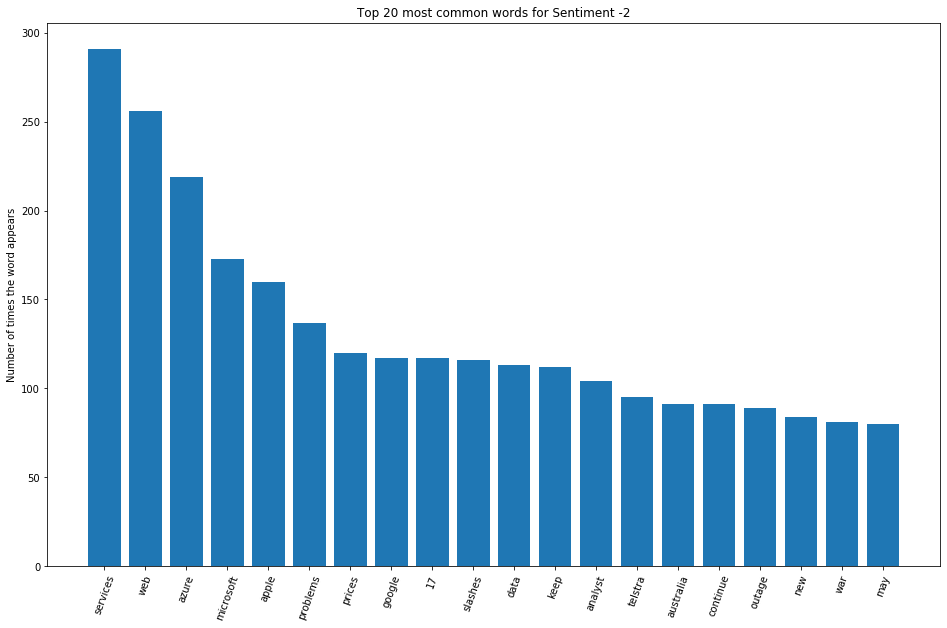

In [34]:
mostcommonwords20sentneg2 = data_freqdistsentneg2.most_common(20)

plt.figure(figsize=(16, 10))
plt.bar(range(len(mostcommonwords20sentneg2)), [val[1] for val in mostcommonwords20sentneg2], align='center')
plt.xticks(range(len(mostcommonwords20sentneg2)), [val[0] for val in mostcommonwords20sentneg2])
plt.xticks(rotation=70)
plt.ylabel('Number of times the word appears')
plt.title('Top 20 most common words for Sentiment -2')
plt.show()

In [35]:
dfsentneg3 = df.loc[df['sentiment'] == -3.0]
dfsentneg3['text']

dfsentneg3['text'].dropna(inplace=True)

datasentneg3 = list(map(process_things, dfsentneg3['text']))
datasentneg3

alldatasentneg3 = [item for elem in datasentneg3 for item in elem]
alldatasentneg3

data_freqdistsentneg3 = FreqDist(alldatasentneg3)
data_freqdistsentneg3.most_common(20)

[('google', 86),
 ('azure', 66),
 ('another', 45),
 ('apple', 39),
 ('market', 38),
 ('console', 36),
 ('sucks', 35),
 ('bad', 34),
 ('spurns', 31),
 ('stackdriver', 31),
 ('services', 29),
 ('today', 26),
 ('like', 25),
 ('day', 24),
 ('time', 23),
 ('dumb', 23),
 ('kills', 23),
 ('use', 23),
 ('hate', 22),
 ('public', 22)]

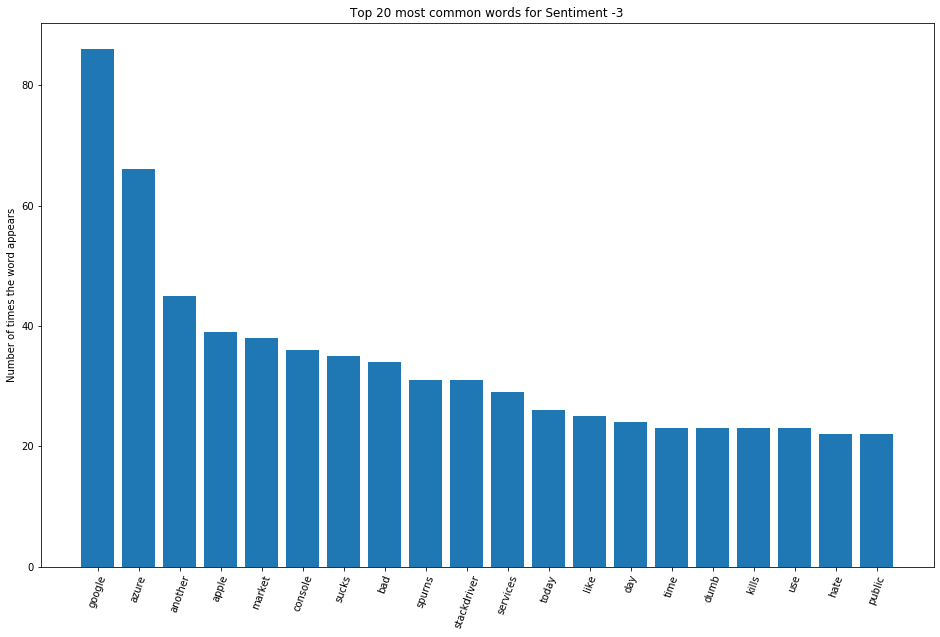

In [36]:
mostcommonwords20sentneg3 = data_freqdistsentneg3.most_common(20)

plt.figure(figsize=(16, 10))
plt.bar(range(len(mostcommonwords20sentneg3)), [val[1] for val in mostcommonwords20sentneg3], align='center')
plt.xticks(range(len(mostcommonwords20sentneg3)), [val[0] for val in mostcommonwords20sentneg3])
plt.xticks(rotation=70)
plt.ylabel('Number of times the word appears')
plt.title('Top 20 most common words for Sentiment -3')
plt.show()

# Bigrams, Trigrams

In [37]:
# One without removing any common words to see common n-grams.

def n_gramall(df_col, n=None):
    # Build the vectorizer, specify inputted n-gram, remove stop words
    vect = CountVectorizer(ngram_range = (n,n), stop_words = gramstopwords_list, min_df = 10)
    # fit/transform vectorizer on specified column
    vect_fit = vect.fit_transform(df_col.values.astype('U'))
    # get all words and store in a list
    word_list = vect.get_feature_names()
    # get a count of all the words
    count_list = vect_fit.toarray().sum(axis=0)
    #create a dictionary of word to count pairings
    count_dict = dict(zip(word_list, count_list))
    # sort the dictionary to show highest counted words on top
    sort_vocab = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)
    return sort_vocab

# One with removing common words to see if any more notable n-grams show up.

def n_gram(df_col, n=None):

    vect = CountVectorizer(ngram_range = (n,n), stop_words = stopwords_list, min_df = 10)

    vect_fit = vect.fit_transform(df_col.values.astype('U'))

    word_list = vect.get_feature_names()

    count_list = vect_fit.toarray().sum(axis=0)

    count_dict = dict(zip(word_list, count_list))

    sort_vocab = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)
    return sort_vocab

In [38]:
gramstopwords_list = stopwords.words('english') + list(string.punctuation)
gramstopwords_list += ["''", '""', '...', '``']

# Bigram/Trigram for entire word list

In [39]:
bigramall = n_gramall(df['text'], n=2)
bigramall[:20]

[('rt awscloud', 8179),
 ('amazon web', 8176),
 ('web services', 8118),
 ('aws lambda', 4493),
 ('aws cloud', 3025),
 ('new aws', 1920),
 ('seattle wa', 1878),
 ('rt jeffbarr', 1732),
 ('amazon aws', 1630),
 ('job awscloud', 1604),
 ('cloud aws', 1510),
 ('using aws', 1490),
 ('jobs jobsearch', 1469),
 ('awscloud new', 1434),
 ('aws azure', 1271),
 ('google cloud', 1266),
 ('engineer aws', 1264),
 ('aws iot', 1224),
 ('awscloud aws', 1161),
 ('aws google', 1099)]

In [40]:
trigramall = n_gramall(df['text'], n=3)
trigramall[:20]

[('amazon web services', 8059),
 ('rt awscloud new', 1314),
 ('seattle wa seattle', 811),
 ('wa seattle wa', 807),
 ('jobs seattle wa', 806),
 ('seattle wa jobs', 783),
 ('wa jobs jobsearch', 765),
 ('web services aws', 700),
 ('software development engineer', 652),
 ('rt awscloud aws', 649),
 ('aws certificate manager', 643),
 ('rt awscloud learn', 609),
 ('awscloud new aws', 597),
 ('database migration service', 597),
 ('aws database migration', 552),
 ('rt awscloud amazon', 529),
 ('lessons 10 years', 502),
 ('10 lessons 10', 487),
 ('rt jeffbarr new', 485),
 ('high performance computing', 467)]

#### Still seems like there's a lot of random text

In [41]:
bigram = n_gram(df['text'], n=2)
bigram[:20]

[('web services', 8118),
 ('seattle wa', 1878),
 ('jobs jobsearch', 1469),
 ('devops engineer', 953),
 ('software development', 914),
 ('10 years', 891),
 ('wa seattle', 871),
 ('jobs seattle', 811),
 ('big data', 801),
 ('certificate manager', 796),
 ('wa jobs', 783),
 ('ssl tls', 767),
 ('development engineer', 755),
 ('57 10', 721),
 ('api gateway', 702),
 ('database migration', 649),
 ('migration service', 635),
 ('microsoft azure', 622),
 ('software engineer', 581),
 ('best practices', 557)]

In [42]:
trigram = n_gram(df['text'], n=3)
trigram[:20]

[('seattle wa seattle', 813),
 ('wa seattle wa', 808),
 ('jobs seattle wa', 806),
 ('seattle wa jobs', 783),
 ('wa jobs jobsearch', 765),
 ('software development engineer', 652),
 ('database migration service', 603),
 ('lessons 10 years', 502),
 ('10 lessons 10', 487),
 ('high performance computing', 467),
 ('ssl tls certificates', 462),
 ('new bigdata blog', 430),
 ('bolsters high performance', 427),
 ('performance computing offering', 425),
 ('years web services', 421),
 ('10 years web', 419),
 ('computing offering nice', 404),
 ('asia pacific seoul', 400),
 ('offering nice acquisition', 398),
 ('pacific seoul region', 381)]

# Bigram/Trigram for Sentiment value 0

In [43]:
bigramsent0 = n_gram(dfsent0['text'], n=2)
bigramsent0[:20]

[('web services', 6396),
 ('seattle wa', 1851),
 ('jobs jobsearch', 1461),
 ('software development', 895),
 ('wa seattle', 868),
 ('devops engineer', 842),
 ('jobs seattle', 811),
 ('wa jobs', 781),
 ('development engineer', 739),
 ('10 years', 684),
 ('57 10', 623),
 ('big data', 579),
 ('software engineer', 562),
 ('certificate manager', 553),
 ('hiring software', 540),
 ('migration service', 540),
 ('database migration', 533),
 ('api gateway', 497),
 ('bigdata blog', 494),
 ('azure functions', 469)]

In [44]:
trigramsent0 = n_gram(dfsent0['text'], n=3)
trigramsent0[:20]

[('seattle wa seattle', 813),
 ('wa seattle wa', 808),
 ('jobs seattle wa', 806),
 ('seattle wa jobs', 781),
 ('wa jobs jobsearch', 765),
 ('software development engineer', 636),
 ('database migration service', 516),
 ('lessons 10 years', 454),
 ('10 lessons 10', 441),
 ('new bigdata blog', 410),
 ('10 years web', 378),
 ('years web services', 378),
 ('asia pacific seoul', 353),
 ('pacific seoul region', 334),
 ('said move part', 330),
 ('move part business', 328),
 ('part business google', 309),
 ('apple said move', 304),
 ('new public sector', 295),
 ('public sector blog', 295)]

# Bigram/Trigram for Positive Sentiment values

In [45]:
bigramsent1 = n_gram(dfsent1['text'], n=2)
bigramsent1[:20]

[('web services', 628),
 ('join us', 529),
 ('ssl tls', 362),
 ('free ssl', 310),
 ('tls certificates', 310),
 ('game engine', 309),
 ('offering free', 236),
 ('lumberyard free', 204),
 ('ios android', 198),
 ('today free', 193),
 ('certificate manager', 192),
 ('certificates free', 192),
 ('certificates customers', 191),
 ('free https', 191),
 ('https certificates', 190),
 ('provides ssl', 190),
 ('along letsencrypt', 189),
 ('customers along', 189),
 ('launches tool', 189),
 ('web apps', 189)]

In [46]:
trigramsent1 = n_gram(dfsent1['text'], n=3)
trigramsent1[:20]

[('ssl tls certificates', 301),
 ('free https certificates', 190),
 ('certificates customers along', 189),
 ('customers along letsencrypt', 189),
 ('https certificates customers', 189),
 ('offering free https', 189),
 ('konklone offering free', 188),
 ('launches tool provides', 188),
 ('tool provides ssl', 187),
 ('provides ssl tls', 186),
 ('tls certificates free', 186),
 ('amp web apps', 185),
 ('android amp web', 185),
 ('ios android amp', 185),
 ('start today free', 185),
 ('apps real phones', 170),
 ('phones tablets start', 170),
 ('real phones tablets', 170),
 ('tablets start today', 170),
 ('test ios android', 170)]

In [47]:
bigramsent2 = n_gram(dfsent2['text'], n=2)
bigramsent2[:20]

[('web services', 443),
 ('spot instances', 223),
 ('helps buy', 190),
 ('spotinst helps', 189),
 ('buy spot', 187),
 ('instances raises', 183),
 ('raises 2m', 178),
 ('2m series', 169),
 ('cloudformation supports', 153),
 ('api gateway', 125),
 ('open source', 112),
 ('rds supports', 101),
 ('swift runtime', 101),
 ('ibm launches', 99),
 ('lambda competitor', 99),
 ('launches swift', 99),
 ('source lambda', 98),
 ('save date', 95),
 ('elasticache supports', 94),
 ('custom authorizers', 90)]

In [48]:
trigramsent2 = n_gram(dfsent2['text'], n=3)
trigramsent2[:20]

[('spotinst helps buy', 189),
 ('helps buy spot', 187),
 ('buy spot instances', 184),
 ('spot instances raises', 183),
 ('instances raises 2m', 176),
 ('raises 2m series', 169),
 ('ibm launches swift', 98),
 ('open source lambda', 97),
 ('launches swift runtime', 95),
 ('source lambda competitor', 92),
 ('runtime open source', 90),
 ('swift runtime open', 90),
 ('lambda competitor github', 82),
 ('competitor github enterprise', 81),
 ('new scheduled reserved', 73),
 ('scheduled reserved instances', 73),
 ('database migration service', 72),
 ('almighty msg hrt', 71),
 ('class care everything', 71),
 ('divine voice mashup', 71)]

In [49]:
bigramsent3 = n_gram(dfsent3['text'], n=2)
bigramsent3[:20]

[('high performance', 455),
 ('performance computing', 453),
 ('computing offering', 422),
 ('bolsters high', 420),
 ('nice acquisition', 418),
 ('offering nice', 406),
 ('web services', 301),
 ('best practices', 182),
 ('10 years', 144),
 ('celebrating 10', 67),
 ('10th birthday', 56),
 ('happy 10th', 56),
 ('terms service', 55),
 ('microsoft azure', 53),
 ('years awscloud10', 52),
 ('techcrunch bolsters', 51),
 ('excited announce', 44),
 ('firm nice', 44),
 ('zombie apocalypse', 42),
 ('acquires nice', 40)]

In [50]:
trigramsent3 = n_gram(dfsent3['text'], n=3)
trigramsent3[:20]

[('high performance computing', 453),
 ('performance computing offering', 422),
 ('bolsters high performance', 420),
 ('computing offering nice', 402),
 ('offering nice acquisition', 396),
 ('celebrating 10 years', 67),
 ('10 years awscloud10', 52),
 ('happy 10th birthday', 51),
 ('techcrunch bolsters high', 51),
 ('apocalypse ready someone', 40),
 ('ready someone must', 40),
 ('service zombie apocalypse', 40),
 ('someone must bet', 40),
 ('terms service zombie', 40),
 ('zombie apocalypse ready', 40),
 ('best practices securing', 39),
 ('dps terms service', 39),
 ('nice acquisition ron_miller', 39),
 ('announcing industry best', 37),
 ('industry best practices', 37)]

# Bigram/Trigram for Negative Sentiment values

In [51]:
bigramsentneg1 = n_gram(dfsentneg1['text'], n=2)
bigramsentneg1[:20]

[('price cuts', 163),
 ('google says', 107),
 ('web services', 96),
 ('cuts prices', 83),
 ('cuts still', 79),
 ('says price', 79),
 ('still way', 78),
 ('way cheaper', 78),
 ('c4 m4', 66),
 ('r3 c4', 65),
 ('prices r3', 63),
 ('m4 instances', 61),
 ('cuts azure', 58),
 ('microsoft cuts', 56),
 ('abandons challenge', 55),
 ('challenge dreams', 55),
 ('dreams makes', 55),
 ('makes eyes', 55),
 ('openstack abandons', 55),
 ('eyes telcos', 54)]

In [52]:
trigramsentneg1 = n_gram(dfsentneg1['text'], n=3)
trigramsentneg1[:20]

[('google says price', 79),
 ('price cuts still', 79),
 ('says price cuts', 79),
 ('cuts still way', 78),
 ('still way cheaper', 78),
 ('cuts prices r3', 63),
 ('prices r3 c4', 63),
 ('r3 c4 m4', 62),
 ('c4 m4 instances', 61),
 ('microsoft cuts azure', 56),
 ('abandons challenge dreams', 55),
 ('challenge dreams makes', 55),
 ('dreams makes eyes', 55),
 ('openstack abandons challenge', 55),
 ('makes eyes telcos', 54),
 ('cuts azure prices', 50),
 ('cuts data transfer', 42),
 ('data transfer fees', 42),
 ('fees academic research', 42),
 ('transfer fees academic', 42)]

In [53]:
bigramsentneg2 = n_gram(dfsentneg2['text'], n=2)
bigramsentneg2[:20]

[('web services', 247),
 ('azure prices', 113),
 ('slashes azure', 113),
 ('microsoft slashes', 111),
 ('17 keep', 110),
 ('prices 17', 110),
 ('problems australia', 91),
 ('australia continue', 90),
 ('telstra problems', 90),
 ('continue web', 89),
 ('services outage', 87),
 ('abandon web', 77),
 ('services data', 77),
 ('data centers', 76),
 ('apple predicted', 74),
 ('predicted abandon', 74),
 ('analyst says', 67),
 ('centers analyst', 67),
 ('best dropdown', 44),
 ('deal may', 44)]

In [54]:
trigramsentneg2 = n_gram(dfsentneg2['text'], n=3)
trigramsentneg2[:20]

[('slashes azure prices', 113),
 ('microsoft slashes azure', 111),
 ('azure prices 17', 110),
 ('prices 17 keep', 110),
 ('problems australia continue', 90),
 ('telstra problems australia', 90),
 ('australia continue web', 89),
 ('continue web services', 89),
 ('web services outage', 87),
 ('abandon web services', 77),
 ('web services data', 77),
 ('services data centers', 75),
 ('apple predicted abandon', 74),
 ('predicted abandon web', 74),
 ('centers analyst says', 67),
 ('data centers analyst', 67),
 ('best dropdown world', 44),
 ('deal may know', 44),
 ('know best dropdown', 44),
 ('may know best', 44)]

In [55]:
bigramsentneg3 = n_gram(dfsentneg3['text'], n=2)
bigramsentneg3[:20]

[('azure sucks', 31),
 ('google spurns', 31),
 ('spurns azure', 31),
 ('stackdriver console', 31),
 ('sucks stackdriver', 31),
 ('al jayab', 24),
 ('younis al', 20),
 ('another day', 19),
 ('another market', 19),
 ('cert market', 19),
 ('day another', 19),
 ('kills today', 19),
 ('market kills', 19),
 ('ssl cert', 19),
 ('today ssl', 19),
 ('ajsharp another', 18),
 ('azure locations', 15),
 ('combined suck', 15),
 ('google combined', 15),
 ('locations google', 15)]

In [56]:
trigramsentneg3 = n_gram(dfsentneg3['text'], n=3)
trigramsentneg3[:20]

[('azure sucks stackdriver', 31),
 ('google spurns azure', 31),
 ('spurns azure sucks', 31),
 ('sucks stackdriver console', 31),
 ('another day another', 19),
 ('another market kills', 19),
 ('day another market', 19),
 ('kills today ssl', 19),
 ('market kills today', 19),
 ('ssl cert market', 19),
 ('today ssl cert', 19),
 ('younis al jayab', 19),
 ('ajsharp another day', 18),
 ('azure locations google', 15),
 ('combined suck google', 15),
 ('google combined suck', 15),
 ('locations google combined', 15),
 ('mohammed younis al', 15),
 ('ptb azure locations', 15),
 ('dumb move telcos', 14)]